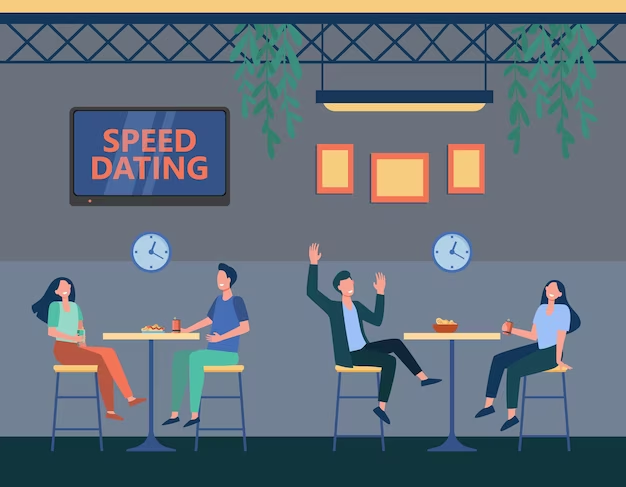

# **Problem formulation:**



**Problem description:** 

- building a machine learning model to predict the probability (0-1, float) output that the dating will match.

**What is the input?**
- inputs : (191 features) for both training set (5909 observations) and (9842 observations) after the oversampling and test set (2469 observations)

**What is the output?**
- output : 1 feature 2469 observations as output (Using Test Data)

**What data mining function is required?**


1.   Data preparation
2.   Splitting the data
3.   Choosing an algorithm(binary classification algorithms)
4.   Model training
5.   Model evaluation



**What could be the challenges?** 

  - our dataset has a lot of null values 
  - an imbalanced dataset a lot 0's and less of 1's im tha target column classes

**What is the impact?**

 A Speed Dating Match Prediction model could potentially increase the efficiency of speed dating events by helping to match participants with compatible partners more quickly and accurately.

**What is an ideal solution?**

Model(best solution **for test set**) :  **bold text**
- baysian search
- cross validation (cv=5)
- XGBoost Classifier 
- Scoring with roc_auc

**the best parameters was:**
 - subsample: 0.8613310939021497,  ratio of the training instances.
 - n_estimators: 400 , The number of trees in the forest.
 - max_depth: 92, The maximum depth of the tree
 - learning_rate: 0.08718154034869337
 - gamma: 0.00042566241677491226 , Minimum loss reduction required to make a further partition on a leaf node of the tree. 
 
 ROC-AUC result: on the training set 0.9983241529781276
 Accuracy result: on the test set on kaggle 88.714%
  


# **Part 1: Data preparation and exploring the challenges**

**Import Libraries**

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler , StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from pandas.core.arrays import numeric
from sklearn.model_selection import train_test_split
from skopt.space import Categorical ,Integer ,Real
from sklearn.pipeline import Pipeline
from pandas.core.arrays import numeric
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

**Load the data**


In [ ]:
#train data
df= pd.read_csv("train.csv")
#test data
test= pd.read_csv("test.csv")
df

,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,...,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,id
0,0,3,2,14,18,2,2.0,14,12,372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2583
1,1,14,1,3,10,2,NaN,8,8,63.0,...,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,6830
2,1,14,1,13,10,8,8.0,10,10,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4840
3,1,38,2,9,20,18,13.0,6,7,200.0,...,9.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,5508
4,1,24,2,14,20,6,6.0,20,17,357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,0,1,2,9,20,2,2.0,18,1,214.0,...,12.0,12.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,3390
5905,1,24,2,9,20,19,15.0,5,6,199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4130
5906,0,13,2,11,21,5,5.0,3,18,290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1178
5907,1,10,2,7,16,6,14.0,9,10,151.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5016


In [ ]:
#print the number of columns in the different data types
df.dtypes.value_counts()

float64    173
int64       11
object       8
dtype: int64

**There is data imbalance for the target column**

<Axes: xlabel='count', ylabel='match'>

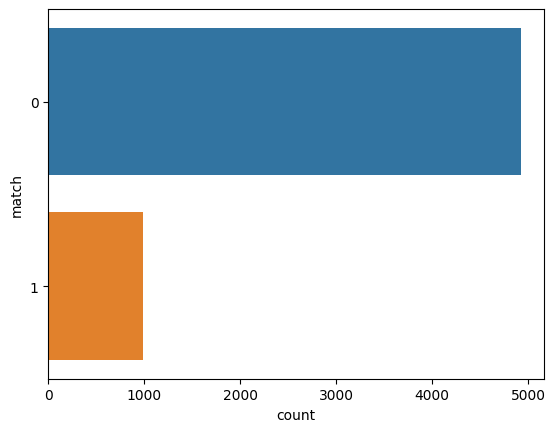

In [ ]:
#plot the target column classes
sns.countplot(y="match", data=df)
# We can see that the data is Imbalanced

**Check for Nulls**

this problem will be resolved laterm with imputer in Pipeline

In [ ]:
#Get the percentage of nulls in each column
df.isnull().mean()

gender      0.000000
idg         0.000000
condtn      0.000000
wave        0.000000
round       0.000000
              ...   
sinc5_3     0.760873
intel5_3    0.760873
fun5_3      0.760873
amb5_3      0.760873
id          0.000000
Length: 192, dtype: float64

In [ ]:
# Make mask to print the columns with null values
mask= df.isnull().any(axis=0)
col_with_nan= df.columns[mask]
df[col_with_nan]

,positin1,pid,int_corr,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,2.0,372.0,-0.03,27.0,2.0,30.00,15.00,15.00,20.00,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,63.0,0.21,24.0,4.0,5.00,15.00,45.00,25.00,0.00,...,6.0,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
2,8.0,331.0,0.43,34.0,2.0,15.00,15.00,10.00,25.00,10.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.0,200.0,0.72,25.0,2.0,13.21,18.87,18.87,16.98,16.98,...,8.0,9.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN
4,6.0,357.0,0.33,27.0,4.0,15.00,20.00,20.00,20.00,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,2.0,214.0,-0.22,23.0,2.0,17.02,21.28,17.02,21.28,14.89,...,12.0,12.0,12.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN
5905,15.0,199.0,0.08,30.0,2.0,17.50,17.50,20.00,12.50,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5906,5.0,290.0,0.35,34.0,2.0,30.00,10.00,30.00,10.00,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5907,14.0,151.0,0.45,28.0,2.0,14.55,16.36,18.18,18.18,16.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Get the columns with object datatype**

In [ ]:
df.select_dtypes(include=['object'])

,field,undergra,mn_sat,tuition,from,zipcode,income,career
0,Ed.D. in higher education policy at TC,University of Michigan-Ann Arbor,"1,290.00","21,645.00","Palo Alto, CA",NaN,NaN,University President
1,Engineering,NaN,NaN,NaN,"Boston, MA","2,021",NaN,Engineer or iBanker or consultant
2,Urban Planning,"Rizvi College of Architecture, Bombay University",NaN,NaN,"Bombay, India",NaN,NaN,Real Estate Consulting
3,International Affairs,NaN,NaN,NaN,"Washington, DC","10,471","45,300.00",public service
4,Business,Harvard College,"1,400.00","26,019.00",Midwest USA,"66,208","46,138.00",undecided
...,...,...,...,...,...,...,...,...
5904,Clinical Psychology,NaN,NaN,NaN,New York,"11,803","65,708.00",Psychologist
5905,MBA,NaN,NaN,NaN,Colombia,NaN,NaN,Consulting
5906,MA Science Education,University of Washington,"1,155.00","13,258.00",Seattle,"98,115","37,881.00",Teacher
5907,Biochemistry,NaN,NaN,NaN,Canada,NaN,NaN,pharmaceuticals and biotechnology


# **Part 2: Data preprocessing and solving the challenges**

**Convert the numerical columns in string fromat to float**

In [ ]:
# Remove the commas to vavethe ability to convert to 
df['tuition']=df['tuition'].str.replace((","), (""))
df['income']=df['income'].str.replace((","), (""))
df['zipcode']=df['zipcode'].str.replace((","), (""))

test['tuition']=test['tuition'].str.replace((","), (""))
test['income']=test['income'].str.replace((","), (""))
test['zipcode']=test['zipcode'].str.replace((","), (""))

In [ ]:
# Convert to float
df['tuition']=df['tuition'].astype(float)
df['income']=df['income'].astype(float)
df['zipcode']=df['zipcode'].astype(float)

test['tuition']=test['tuition'].astype(float)
test['income']=test['income'].astype(float)
test['zipcode']=test['zipcode'].astype(float)
test['id']=test['id'].astype('int')

**Categorical encoding of all object data**

to deal with the rest of columns with object datatype

In [ ]:
#get the oject data
obj_train=df.select_dtypes(include=['object']) 
obj_test=test.select_dtypes(include=['object']) 

# convert to categorical
for i in obj_train:
    df[i]=df[i].astype("category")

for i in obj_test:
    test[i]=test[i].astype("category")



In [ ]:
# separate tha input data to train data and target column
Xtrain=df.drop(["match"],axis=1)
ytrain=df['match']

In [ ]:
# get the data shape 
print("Training Date Shape: ", Xtrain.shape)
print("Label Date Shape: ", ytrain.shape)

Training Date Shape:  (5909, 191)
Label Date Shape:  (5909,)


**RandomOverSampleris** 

to solve the problem of data imbalance specially for target column

In [ ]:
# RandomOverSampling 
ros = RandomOverSampler(random_state=0)
Xtrain, ytrain = ros.fit_resample(Xtrain, ytrain)

In [ ]:
#get the shape after overSampling
print("Training Date Shape: ", Xtrain.shape)
print("Label Date Shape: ", ytrain.shape)

Training Date Shape:  (9842, 191)
Label Date Shape:  (9842,)


**Target coulmn after oversampling**

We can see that the data imbalance has been resolved 

<Axes: >

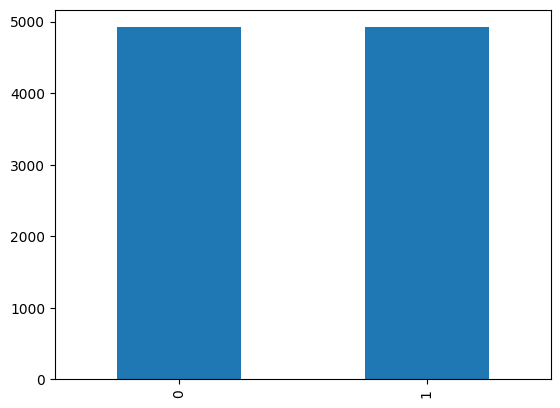

In [ ]:
#plot the target column classes after overSampling
ytrain.value_counts().plot(kind ='bar')


**Extract numeric features and categorical features names**

In [ ]:
# numeric features 
features_numeric = list(Xtrain.select_dtypes(include=['float64', 'int64']))

# categorical features
features_categorical = list(Xtrain.select_dtypes(include=['category']))

print('numeric features:', features_numeric)
print('categorical features:', features_categorical)

numeric features: ['gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'partner', 'pid', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field_cd', 'tuition', 'race', 'imprace', 'imprelig', 'zipcode', 'income', 'goal', 'date', 'go_out', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'm

# **Part 3: Model Building**

##**Choosing an algorithm**


**General things used in the pipeline for all the trials**
- **cross validation** (cv=5):

 - repeatedly splitting the data into training and testing sets.

 - It helps to prevent overfitting and provides a more accurate estimate of the model's performance on unseen data.

- **SimpleImputer**:
  - to fill the null values un the data with the stratigy we picked that is "mean" value of each feature
  -Dealing with numerical and categorical features

- **StandardScaler**:

   - standardize features by removing the mean and scaling to unit variance. 
   - we use it to deal with the different scale in the data
- **OneHotEncoder**:
   encode categorical features as a one-hot numeric array. 





##**Define pipe line**

In [ ]:
np.random.seed(0)

# define a pipe line for numeric feature preprocessing
# we gave them a name so we can set their hyperparameters
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())]
)

# define a pipe line for categorical feature preprocessing
# we gave them a name so we can set their hyperparameters
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
# define the preprocessor 
# we gave them a name so we can set their hyperparameters
# we also specify what are the categorical 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# combine the preprocessor with the model as a full tunable pipeline
# we gave them a name so we can set their hyperparameters
full_pipline_1 = Pipeline(
    steps=[
       
          ('preprocessor', preprocessor)
           ,('my_classifier', 
           LogisticRegression(), # LogisticRegression as a classifier.
        )

    ]      
)
full_pipline_1
full_pipline_2 = Pipeline(
    steps=[
       
          ('preprocessor', preprocessor)
           ,('my_classifier', 
           RandomForestClassifier(), # RandomForestClassifier as a classifier.
        )

    ]      
)
full_pipline_2
full_pipline = Pipeline(
    steps=[
         ('preprocessor', preprocessor), 
        ('my_classifier', 
           XGBClassifier(), # XGBClassifier as a classifier.
        )
    ]      
  
)

full_pipline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_fun', 'pf_o_amb',
                                                   'pf_o_sha', 'attr_o',
                                                   'sinc...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## **LogisticRegression Model**

**Logistic Regression is a simple and effective classification algorithm used to predict the probability of an instance belonging to a particular class.it's so effictive with binary classification problem.**

here we will use:
- random search
- cross validation (cv=5)
- logistic regression Classifier
- Scoring with roc_auc


in this trial we used RandomSearch to get the best parameters
**that was:**
- **solver: liblinear** that is **Algorithm to use in the optimization problem**
-**max_iter: 100** as we see it picked **the largest number** of iterations because of **the high complexity** of the data
- **C : 1** that is **Inverse of regularization strength** and '1' means **No regularization**, which  is better when a large amount of data available and the model is not overfitting. 

**Oservation:**

 from the Result we got It is too Simple as expected to deal with all this data that was to complex for it.

### **RandomSearch**
 
**Random search randomly picks hyperparameter combinations from a grid and evaluates the model performance.**


In [ ]:
# Define parameters for RandomSearch for XGBoost
LogReg_param = {
#Inverse of regularization strength
  'my_classifier__C': [0.001,0.01,0.1,1],
#
  'my_classifier__max_iter': [30,50,80,100],
#
  'my_classifier__solver': ['lbfgs', 'liblinear', 'sag'],
}
# Create RandomizedSearch objects with roc_auc score
LogReg_random = RandomizedSearchCV(full_pipline_1, LogReg_param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)

# Get best models
LogReg_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_fun', 'pf_o_amb',
                                                   'pf_o_sha', 'attr_o',
                                                   'sinc_o', 'intel_o', 'fun_o',
                                                   'amb_o', 'shar_o', 'like_o',
                                                   'prob_o', 'met_o', 'age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['field', 'undergra',
                                                   'mn_sat', 'from',
                                                   'career'])])),
                ('my_classifier', LogisticRegression(C=1, solver='liblinear'))])

In [ ]:
# Get best parameters
LogReg_random.best_params_

{'my_classifier__solver': 'liblinear',
 'my_classifier__max_iter': 100,
 'my_classifier__C': 1}

In [ ]:
# Get best roc_auc score 
LogReg_random.best_score_

0.9153530806804291

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = LogReg_random.predict_proba(test)[:,1]

submission1.to_csv('submission_LogReg.csv', index=False)  

## **RandomForestClassifier**

**Random Forest is an ensemble-based classification algorithm that constructs a multitude of decision trees and aggregates their predictions to make the final classification decision. It is accurate, robust, and can handle both categorical and numerical features. and it's much more complex than the Logistic regression model .**

here we will use:

- random search to get the best parameters
- cross validation (cv=5)
- RandomForestClassifier 
- Scoring with roc_auc

**the best parameters was:**

- criterion: 'gini' , The function to measure the quality of a split.
- max_depth: 100 , The maximum depth of the tree
- max_features: 'auto', The number of features to consider when looking for the best split depending on n_estimators.
- min_samples_split: 3, The minimum number of samples required to split an internal node
- n_estimators: 500, The number of trees in the forest

**Observation:** the model got very close roc_auc  in random and baysian searchthat is greater than the one ib linear Regression model thet happened beacause of the coplexity of the model that fitted the complexity of the data.



### **RandomSearch**
 
**Random search randomly picks hyperparameter combinations from a grid and evaluates the model performance.**


In [ ]:
# Define parameters for RandomSearch for RandomForest
RandomForest_param = {
   #The number of trees in the forest
    'my_classifier__n_estimators': Categorical([400, 500]),
    #The maximum depth of the tree
    'my_classifier__max_depth': [3,100],
    #The number of features to consider when looking for the best split depending on n_estimators 
    'my_classifier__max_features': Categorical(['auto', 'sqrt']),
    #The function to measure the quality of a split.
    'my_classifier__criterion': Categorical(['gini']),
    #The minimum number of samples required to split an internal node
    'my_classifier__min_samples_split':[3,10]
}

# Create RandomizedSearch objects with roc_auc score
RandomForest_random = RandomizedSearchCV(full_pipline_2, RandomForest_param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)

# Get best models
RandomForest_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_fun', 'pf_o_amb',
                                                   'pf_o_sha', 'attr_o',
                                                   'sinc_o', 'intel_o', 'fun_o',
                                                   'amb_o', 'shar_o', 'like_o',
                                                   'prob_o', 'met_o', 'age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['field', 'undergra',
                                                   'mn_sat', 'from',
                                                   'career'])])),
                ('my_classifier',
                 RandomForestClassifier(max_depth=100, min_samples_split=3,
                                        n_estimators=400))])

In [ ]:
# Get best parameters
RandomForest_random.best_params_

{'my_classifier__criterion': 'gini',
 'my_classifier__max_depth': 100,
 'my_classifier__max_features': 'sqrt',
 'my_classifier__min_samples_split': 3,
 'my_classifier__n_estimators': 400}

In [ ]:
# Get best roc_auc score 
RandomForest_random.best_score_

0.9991040818000727

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = RandomForest_random.predict_proba(test)[:,1]

submission1.to_csv('submission_randomForest.csv', index=False)  

### **Bayesian search**
**Bayesian search is an optimization algorithm that sequentially uses a model-based approach to determine the next hyperparameter value based on the results of the previous iteration.**

In [ ]:
# Define parameters for RandomSearch for RandomForest
RandomForest_param = {
   #The number of trees in the forest
    'my_classifier__n_estimators': Categorical([400, 500]),
    #The maximum depth of the tree
    'my_classifier__max_depth': [3,100],
    #The number of features to consider when looking for the best split depending on n_estimators 
    'my_classifier__max_features': Categorical(['auto', 'sqrt']),
    #The function to measure the quality of a split.
    'my_classifier__criterion': Categorical(['gini']),
    #The minimum number of samples required to split an internal node
    'my_classifier__min_samples_split':[3,10]
}

# Create RandomizedSearch objects with roc_auc score
RandomForest_Bayesian = BayesSearchCV(full_pipline_2, RandomForest_param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)

# Get best models
RandomForest_Bayesian.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   'pf_o_fun', 'pf_o_amb',
                                                   'pf_o_sha', 'attr_o',
                                                   'sinc_o', 'intel_o', 'fun_o',
                                                   'amb_o', 'shar_o', 'like_o',
                                                   'prob_o', 'met_o', 'age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['field', 'undergra',
                                                   'mn_sat', 'from',
                                                   'career'])])),
                ('my_classifier',
                 RandomForestClassifier(max_depth=100, min_samples_split=3,
                                        n_estimators=500))])

In [ ]:
# Get best parameters
RandomForest_Bayesian.best_params_

OrderedDict([('my_classifier__criterion', 'gini'),
             ('my_classifier__max_depth', 100),
             ('my_classifier__max_features', 'sqrt'),
             ('my_classifier__min_samples_split', 3),
             ('my_classifier__n_estimators', 500)])

In [ ]:
# Get best roc_auc score 
RandomForest_Bayesian.best_score_

0.9991529036831472

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = RandomForest_Bayesian.predict_proba(test)[:,1]

submission1.to_csv('submission_randomForest.csv', index=False)  

## **XGBoost Model**



algorithm that uses a combination of decision trees and gradient boosting to create a powerful predictive model.

we used it cause : it's **ability to handle large datasets**, its speed, and its accuracy in prediction.

**Oservation for the next three trials:**

- **First trial & Third trial** : work with the same  hyperparameters 
  - grid search take so much time in training specially that is run on CPU 
  - the output was very close or almost the same so we can say that random search is better in time and the score is too close if we use the same hyperparameters.
-**Second trial**: Baysian search  determine the next hyperparameter value based on the results of the previous iteration.

 - I used the different hyperparameters in this trial .
 - the score was very good and with the test set it got the best accuracy each 88.174%.

### **RandomSearch**
 


**Random search randomly picks hyperparameter combinations from a grid and evaluates the model performance.**
here we will use:

- random search
- cross validation (cv=5)
- XGBoost Classifier 
- Scoring with roc_auc

**the best parameters was:**
 - subsample: 0.9,  ratio of the training instances.
 - n_estimators: 500 , The number of trees in the forest.
 - max_depth: 8, The maximum depth of the tree
 - learning_rate: 0.1
 - gamma: 0 , Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [ ]:
# Define parameters for RandomSearch for XGBoost
XGBoost_param = {
  'my_classifier__n_estimators': [450,500],
  'my_classifier__max_depth': [8,10],
  'my_classifier__learning_rate': [0.01, 0.1, 0.2],
  'my_classifier__gamma': [0, 0.1, 0.2],
  'my_classifier__subsample': [0.8, 0.9, 1]
}
# Create RandomizedSearch objects
XGBoost_random = RandomizedSearchCV(full_pipline, XGBoost_param, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)

# Get best models
XGBoost_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   

In [ ]:
# Get best parameters
XGBoost_random.best_params_

{'my_classifier__subsample': 0.9,
 'my_classifier__n_estimators': 500,
 'my_classifier__max_depth': 8,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__gamma': 0}

In [ ]:
# Get best score
XGBoost_random.best_score_

0.998438931324283

the random search is created the best model in the time of training and also the score with the training data was the best

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = XGBoost_random.predict_proba(test)[:,1]

submission1.to_csv('submission_random.csv', index=False)  

### **Bayesian search**


**Bayesian search is an optimization algorithm that sequentially uses a model-based approach to determine the next hyperparameter value based on the results of the previous iteration.**

- baysian search
- cross validation (cv=5)
- XGBoost Classifier 
- Scoring with roc_auc

**the best parameters was:**
 - subsample: 0.8613310939021497,  ratio of the training instances.
 - n_estimators: 400 , The number of trees in the forest.
 - max_depth: 92, The maximum depth of the tree
 - learning_rate: 0.08718154034869337
 - gamma: 0.00042566241677491226 , Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [ ]:
# Define parameters for BayesSearch for XGBoost
XGBoost_param_bayes = {
   'my_classifier__n_estimators': Categorical([400,500]),
   'my_classifier__max_depth': Integer(3,100),
   'my_classifier__learning_rate':Real(1e-5, 0.2, prior='log-uniform'),
   'my_classifier__gamma':Real(1e-5, 0.2, prior='log-uniform'),
   'my_classifier__subsample':Real(0.5, 1, prior='log-uniform')
 }

 # Create Bayes object
XGBoost_bayes = BayesSearchCV(full_pipline,XGBoost_param_bayes,n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)

 # Get best models
XGBoost_bayes.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   

In [ ]:
 # Get best parameters
XGBoost_bayes.best_params_

OrderedDict([('my_classifier__gamma', 0.00042566241677491226),
             ('my_classifier__learning_rate', 0.08718154034869337),
             ('my_classifier__max_depth', 92),
             ('my_classifier__n_estimators', 400),
             ('my_classifier__subsample', 0.8613310939021497)])

In [ ]:
 # Get best score
XGBoost_bayes.best_score_

0.9983241529781276

**this trial was the best with the test data that got .88714 score with the private test in kaggle because is is based on the results of the previous iteration**

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = XGBoost_bayes.predict_proba(test)[:,1]

submission1.to_csv('submission_bayes.csv', index=False)

### **Grid search**



**Grid search is an exhaustive search that evaluates all possible combinations of hyperparameters to find the optimal hyperparameters.**

- grid search
- cross validation (cv=5)
- XGBoost Classifier 
- Scoring with roc_auc

**the best parameters was:**
 - subsample: 0.9,  ratio of the training instances.
 - n_estimators: 450 , The number of trees in the forest.
 - max_depth: 8, The maximum depth of the tree
 - learning_rate: 0.1
 - gamma: 0 , Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [ ]:
# Define parameters for Grid for XGBoost
XGBoost_param_grid = {
  'my_classifier__n_estimators': [450,500],
   'my_classifier__max_depth': [8,10],
   'my_classifier__learning_rate': [0.01, 0.1, 0.2],
   'my_classifier__gamma': [0, 0.1, 0.2],
   'my_classifier__subsample': [0.8, 0.9, 1]
 }

XGBoost_grid = GridSearchCV(full_pipline, XGBoost_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1).fit(Xtrain, ytrain)
XGBoost_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', 'idg', 'condtn',
                                                   'wave', 'round', 'position',
                                                   'positin1', 'order',
                                                   'partner', 'pid', 'int_corr',
                                                   'samerace', 'age_o',
                                                   'race_o', 'pf_o_att',
                                                   'pf_o_sin', 'pf_o_int',
                                                   

In [ ]:
XGBoost_grid.best_params_

{'my_classifier__gamma': 0,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__max_depth': 8,
 'my_classifier__n_estimators': 450,
 'my_classifier__subsample': 0.9}

In [ ]:
XGBoost_grid.best_score_

0.9984825056124771

In [ ]:
# create csv file for submission

submission1 = pd.DataFrame()

submission1['id'] = test['id']

submission1['match'] = XGBoost_grid.predict_proba(test)[:,1]

submission1.to_csv('submission_grid.csv', index=False)